In [4]:
from glioseg import constants
from pathlib import Path

segmentation_files_dict = {
    "nnUNet": constants.NNUNET_TASK001_TASK082_ENSEMBLE_SEGMENTATION_NAME
    + constants.RELABELLED_NAME,
    "BraTS21": constants.NNUNET_TASK500_ENSEMBLE_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "HDglio": constants.HDGLIO_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "DeepSCAN": constants.SCAN2020_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "FETS": constants.FETS_SEGMENTATION_NAME + constants.RELABELLED_NAME,
}

mean_segmentation_files_dict = {
    "MV": constants.ENSEMBLED_MAJORITY_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "STAPLE": constants.ENSEMBLED_SEGMENTATION_NAME + constants.RELABELLED_NAME,
    "SIMPLE": constants.ENSEMBLED_SIMPLE_SEGMENTATION_NAME + constants.RELABELLED_NAME,
}


input_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/Patients")
gt_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/GT/")
labels = [1, 2, 3]

output_dir = Path("/scratch/radv/share/glioseg/new_run_corrected/segQA")
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
from glioseg.segmentation.tumor.validation.metrics_nnunet import compute_dice_score
from glioseg.segmentation.tumor.validation.metrics_nnunet import extract_label
from glioseg.segmentation.tumor.validation.metrics_nnunet import same_physical_space
import SimpleITK as sitk
import itertools
import numpy as np
import pandas as pd

def compute_confidence_score(input_dir: str | Path, segmentation_dict: dict, labels: list, output_dir: str | Path):

    """
    Compute pairwise Dice similarity coefficients (DSC) and
    mean Dice similarity coefficients (MDSC) between multiple segmentation
    methods for each patient in the input directory.

    Args:
        input_dir (Path or str): Directory containing patient subdirectories with segmentations.
        segmentation_dict (dict): Dictionary mapping method names to segmentation file name suffixes.
        labels (list): List of integer labels to consider for Dice score computation.
        output_dir (Path or str): Directory to save the output CSV files. 
    Returns:
        results (pd.DataFrame): DataFrame containing summary confidence metrics per patient.
        results_extended (pd.DataFrame): DataFrame containing detailed confidence metrics per patient, i.e., the value of the metric
        for all the possible combination between methods. 
    
    """

    if not isinstance(input_dir, Path):
        input_dir = Path(input_dir)
    if not isinstance(output_dir, Path): 
        output_dir = Path(output_dir)

    all_results = []
    all_results_per_patient = []

    for patient in sorted(input_dir.iterdir()):

        segmentations_dir = patient.joinpath(constants.SEGMENTATIONS_FOLDER_NAME, constants.NIFTI_FOLDER_NAME)

        # Load all model segmentations
        seg_images = {}
        for method, seg_file_name in segmentation_dict.items():
            
            seg_file = segmentations_dir.joinpath(
                constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
            ).with_suffix(constants.NIFTI_EXTENSION)

            if seg_file.exists():
                seg_images[method] = sitk.ReadImage(str(seg_file), sitk.sitkUInt8)
            else:
                print(f"Skipping {method}: file not found {seg_file}")

        methods = list(seg_images.keys())
        if len(methods) < 2:
            print(f"Skipping {patient.name}: <2 segmentations.")
            continue

        # Accumulate pairwise macro & micro Dice scores
        macro_scores = {}
        micro_scores = {}

        for m1, m2 in itertools.combinations(methods, 2):
            
            seg1, seg2 = seg_images[m1], seg_images[m2]

            if not same_physical_space(seg1, seg2):
                seg2.CopyInformation(seg1)

            per_label_dices = []
            total_intersection = 0
            total_union = 0

            for label in labels:
                
                s1_label = extract_label(seg1, label)
                s2_label = extract_label(seg2, label)

                # Macro
                dice = compute_dice_score(s1_label, s2_label)
                per_label_dices.append(dice)

                # Micro
                s1_arr = sitk.GetArrayFromImage(s1_label) > 0
                s2_arr = sitk.GetArrayFromImage(s2_label) > 0
                total_intersection += np.sum(s1_arr & s2_arr)
                total_union += np.sum(s1_arr) + np.sum(s2_arr)

            macro_scores[(m1, m2)] = float(np.mean(per_label_dices))

            micro_scores[(m1, m2)] = float(2 * total_intersection / (total_union + 1e-6))

        final_macro = np.mean(list(macro_scores.values()))
        final_micro = np.mean(list(micro_scores.values()))

        all_results.append(
            {
                "Patient": patient.name,
                "PW-DSC": final_macro,
                "PW-MCDSC": final_micro,
            }
        )

        all_results_per_patient.append(
            {
                "Patient": patient.name,
                "PW-DSC-combinations": macro_scores,
                "PW-MCDSC-combinations": micro_scores,
            }
        )

    results_extended = pd.DataFrame(all_results_per_patient)
    output_file_extended = output_dir.joinpath("confidence_extended.csv")
    results_extended.to_csv(output_file_extended, index=False)
    print(f"Extended confidence metrics saved to {output_file_extended}")

    # Save final results
    results = pd.DataFrame(all_results)
    output_file = output_dir.joinpath("confidence_summary.csv")
    results.to_csv(output_file, index=False)
    print(f"Summary confidence metrics saved to {output_file}")

    return results, results_extended

In [6]:
confidence_summary, confidence_extended = compute_confidence_score(
    input_dir=input_dir,
    segmentation_dict=segmentation_files_dict,
    labels=labels,
    output_dir=output_dir,
)

Extended confidence metrics saved to /scratch/radv/share/glioseg/new_run_corrected/segQA/confidence_extended.csv
Summary confidence metrics saved to /scratch/radv/share/glioseg/new_run_corrected/segQA/confidence_summary.csv


In [7]:
def compute_multiclass_dice_score(input_dir: str | Path, gt_dir: str | Path, mean_models_dict: dict, labels: list, output_dir: str | Path):

    """
    Compute multiclass Dice similarity coefficients (MCDSC) between the mean (ensemble) segmentation and 
    the ground truth segmentation. 

    Args:
        input_dir (Path or str): Directory containing patient subdirectories with segmentations.
        gt_dir (Path or str): Directory containing ground truth segmentations.
        mean_models_dict (dict): Dictionary mapping the segmentation files of different mean (ensemble) methods.
        labels (list): List of integer labels to consider for Dice score computation.
        output_dir (Path or str): Directory to save the output CSV file.
    Returns:
        results (pd.DataFrame): DataFrame containing the multiclass Dice scores for each patient and ensemble method.
    """

    if not isinstance(input_dir, Path):
        input_dir = Path(input_dir)
    if not isinstance(gt_dir, Path):
        gt_dir = Path(gt_dir)
    if not isinstance(output_dir, Path):
        output_dir = Path(output_dir)

    all_results = []

    for patient in sorted(input_dir.iterdir()):

        segmentations_dir = patient.joinpath(constants.SEGMENTATIONS_FOLDER_NAME, constants.NIFTI_FOLDER_NAME)
        gt_file = gt_dir.joinpath(patient.name, constants.NIFTI_FOLDER_NAME, "MASK").with_suffix(constants.NIFTI_EXTENSION)

        gt_im = sitk.ReadImage(str(gt_file), sitk.sitkUInt8)

        seg_images = {}

        for method, seg_file_name in mean_models_dict.items():

            seg_file = segmentations_dir.joinpath(
                constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
            ).with_suffix(constants.NIFTI_EXTENSION)

            if not seg_file.exists() and "_relabelled" in seg_file_name:
                seg_file_name = seg_file_name.replace("_relabelled", "")
                print(
                    f"Segmentation file {seg_file} does not exist. Using the non-relabelled output {seg_file_name} instead"
                )
                seg_file = segmentations_dir.joinpath(
                    constants.TUMOR_MASK_NAME + seg_file_name + "_T1GD"
                ).with_suffix(constants.NIFTI_EXTENSION)
            
            if seg_file.exists():
                seg_images[method] = sitk.ReadImage(str(seg_file), sitk.sitkUInt8)
                if not same_physical_space(gt_im, seg_images[method]):
                    seg_images[method].CopyInformation(gt_im)
                dice_scores_labels = []
                total_intersection = 0
                total_union = 0
                for label in labels:
                    gt_label = extract_label(gt_im, label)
                    seg_label = extract_label(seg_images[method], label)

                    gt_arr = sitk.GetArrayFromImage(gt_label) > 0
                    seg_arr = sitk.GetArrayFromImage(seg_label) > 0

                    total_intersection += np.sum(gt_arr & seg_arr)
                    total_union += np.sum(gt_arr) + np.sum(seg_arr)

                    dice_score_per_label = compute_dice_score(gt_label, seg_label)
                    dice_scores_labels.append(dice_score_per_label)

                mean_dice_score_vs_gt = np.mean(dice_scores_labels)
                multiclass_dice_score_vs_gt = 2 * total_intersection / (total_union + 1e-6)
                all_results.append(
                    {
                        "Patient": patient.name,
                        "Method": method,
                        "GT-DSC": mean_dice_score_vs_gt,
                        "GT-MCDSC": multiclass_dice_score_vs_gt,
                    }
                )
            else:
                print(f"Skipping {method}: file not found {seg_file}")
                continue

    results = pd.DataFrame(all_results)
    output_file = output_dir.joinpath("quality.csv")
    results.to_csv(output_file, index=False)
    print(f"Quality results saved to {output_file}")

    return results

In [8]:
multiclass_dice_score = compute_multiclass_dice_score(
    input_dir=input_dir,
    gt_dir=gt_dir,
    mean_models_dict=mean_segmentation_files_dict,
    labels=labels,
    output_dir=output_dir,
)

Quality results saved to /scratch/radv/share/glioseg/new_run_corrected/segQA/quality.csv


In [45]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math
from sklearn.metrics import auc

def plot_quality_vs_risk(
    confidence_candidates_summary_df: pd.DataFrame,
    multiclass_dice_score_df: pd.DataFrame,
    model_keys: str | list[str] | None,
    output_dir: str | Path,
    metric_compute: str,
    experiment_name: str = "",
    fit_line = False,
    desired_coverage = None
):
    """
    Plot PW-DSC (x-axis) vs Risk (1 - GT-DSC) (y-axis) for one or more models.

    Args:
        confidence_candidates_summary_df (pd.DataFrame): Must contain ["Patient", "PW-DSC", "PW-MCDSC"].
        multiclass_dice_score_df (pd.DataFrame): Must contain ["Patient", "Method", "GT-DSC", "GT-MCDSC"].
        model_keys (str | list[str] | None): Model(s) to plot.
            - str : single model plot
            - list[str]: multiple models, one subplot each
            - None: all models found in multiclass_dice_score_df
        output_dir (str | Path): Directory to save outputs.
        metric_compute (str): Type of metric either "macro" or "micro". If "macro", it corresponds to the mean per-label Dice score 
        (PW-DSC), if "micro", it corresponds to the multiclass Dice score (PW-MCDSC).
        experiment_name (str): Name of the experiment to include in the output figure and csv files.
        fit_line (bool): Whether to fit a linear regression line to the scatter plot. Default is False.
        desired_coverage (float | None): If provided, generates a graph with a vertical line at the threshold with the desired
        coverage, indicating both the acceptance and referral regions. 
    """

    output_dir.mkdir(parents=True, exist_ok=True)

    if not isinstance(output_dir, Path):
        output_dir = Path(output_dir)

    # Models to plot
    if model_keys is None:
        models_to_plot = multiclass_dice_score_df["Method"].unique()
    elif isinstance(model_keys, str):
        models_to_plot = [model_keys]
    elif isinstance(model_keys, list):
        models_to_plot = model_keys
    else:
        raise ValueError("model_keys must be None, a string, or a list of strings.")

    assert metric_compute in ["macro", "micro"], "metric_compute must be either 'macro' or 'micro'"

    if metric_compute == "macro":
        GT_key = "GT-DSC"
        confidence_key = "PW-DSC"
    else:
        GT_key = "GT-MCDSC"
        confidence_key = "PW-MCDSC"

    n_models = len(models_to_plot)

    # PLot single vs multiple models 

    if n_models == 1:

        model = models_to_plot[0]
        multiclass_dice_model = multiclass_dice_score_df[
            multiclass_dice_score_df["Method"] == model
        ].copy()
        if multiclass_dice_model.empty:
            print(f"No entries found for model '{model}'")
            return

        multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]

        x, y = (
            confidence_candidates_summary_df[confidence_key].values,
            multiclass_dice_model["Risk"].values,
        )

        r_value, p_value = pearsonr(x, y)

        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, color="tab:blue", edgecolor="k", s=70, alpha=0.8, label=rf"$\rho = {r_value:.3f}$")
        if fit_line:
            slope, intercept = np.polyfit(x, y, 1)
            plt.plot(x, slope * x + intercept, color="red", linewidth=2)
        if desired_coverage is not None:
            
            coverage_threshold = np.percentile(x, 100 * (1 - desired_coverage))
            plt.axvline(x=coverage_threshold, color="black", linestyle="--", linewidth=2, label=f"Coverage threshold ({desired_coverage:.1f})")
            x_min, x_max = plt.xlim()
            y_min, y_max = plt.ylim()
            
            # Shade the left area of the threshold (referral region)

            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)

            plt.fill_betweenx(
                y=[y_min, y_max],
                x1=x_min, 
                x2=coverage_threshold,
                color="red",
                alpha=0.2, 
                label = "Referral region"
            )

            # Shade the right area of the threshold (acceptance region)

            plt.fill_betweenx(
                y=[y_min, y_max], 
                x1=coverage_threshold,
                x2=x_max,
                color="green",
                alpha=0.2,
                label="Acceptance region"
            )

        plt.xlabel(f"Confidence ({confidence_key})")
        plt.ylabel(f"Risk (1- {GT_key})")
        # plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()

        output_file = output_dir / f"conf_vs_risk_{experiment_name}_{metric_compute}.svg"

        plt.tight_layout()
        plt.savefig(output_file)
        plt.show()
        plt.close()

        correlation_summary_df = pd.DataFrame.from_dict({"Model": [model], "Pearson coefficient": [float(r_value)], "p-value": [float(p_value)]})
        correlation_summary_csv = output_dir / f"corr_summary_{experiment_name}_{metric_compute}.csv"
        correlation_summary_df.to_csv(correlation_summary_csv, index=False)

        print(f"Saved scatter plot for model '{model}' to {output_file}")
        print(f"Saved correlation summary to {correlation_summary_csv}")
        print(f"   Pearson r = {r_value:.3f}, p = {p_value:.3e}")
    
    else:
        
        # Multiple models figure

        if n_models <= 3:
            n_rows = 1
            n_cols = n_models
        else:
            n_cols = math.ceil(math.sqrt(n_models))
            n_rows = math.ceil(n_models / n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axes = np.array(axes).flatten()

        correlation_information = []

        for i, model in enumerate(models_to_plot):

            ax = axes[i]
            multiclass_dice_model = multiclass_dice_score_df[
                multiclass_dice_score_df["Method"] == model
            ].copy()

            if multiclass_dice_model.empty:
                ax.set_visible(False)
                continue

            multiclass_dice_model["Risk"] = 1 - multiclass_dice_model[GT_key]
            x, y = (
                confidence_candidates_summary_df[confidence_key].values,
                multiclass_dice_model["Risk"].values,
            )

            r_value, p_value = pearsonr(x, y)

            ax.scatter(x, y, color=f"C{i % 10}", edgecolor="k", s=70, alpha=0.8, label=rf"$\rho = {r_value:.3f}$")

            if fit_line:
                slope, intercept = np.polyfit(x, y, 1)
                ax.plot(x, slope * x + intercept, color="red", linewidth=2)
            if desired_coverage is not None: 
                coverage_threshold = np.percentile(x, 100*(1 - desired_coverage))
                ax.axvline(x=coverage_threshold, color="black", linestyle="--", linewidth=2, label=f"Coverage threshold ({desired_coverage:.1f})")
                x_min, x_max = ax.get_xlim()
                y_min, y_max = ax.get_ylim()

                # Shade the left area of the threshold (referral region)

                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)

                ax.fill_betweenx(
                    y=[y_min, y_max],
                    x1=x_min, 
                    x2=coverage_threshold,
                    color="red",
                    alpha=0.2, 
                    label = "Referral region"
                )

                # Shade the right area of the threshold (acceptance region)

                ax.fill_betweenx(
                    y=[y_min, y_max], 
                    x1=coverage_threshold,
                    x2=x_max,
                    color="green",
                    alpha=0.2,
                    label="Acceptance region"
                )

            ax.set_xlabel(f"Confidence ({confidence_key})")
            ax.set_ylabel(f"Risk (1 - {GT_key})")
            ax.legend()
            # ax.grid(True, linestyle="--", alpha=0.5)

            correlation_information.append({"Model": model, "Pearson coefficient": float(r_value), "p-value": float(p_value)})


        fig.tight_layout(rect=[0, 0, 1, 0.96])

        output_file = output_dir / f"conf_vs_risk_{experiment_name}_{metric_compute}.svg"

        plt.show()
        fig.savefig(output_file)
        plt.close()

        corr_df = pd.DataFrame(correlation_information)
        corr_csv = output_dir / f"corr_summary_{experiment_name}_{metric_compute}.csv"
        corr_df.to_csv(corr_csv, index=False)

        print(f"Saved multi-model figure to {output_file}")
        print(f"Correlation summary saved to {corr_csv}")
        # Get cases that fall in the referral region 
        
    if desired_coverage is not None: 
        referral_cases = confidence_candidates_summary_df[
            confidence_candidates_summary_df[confidence_key] < coverage_threshold
        ]["Patient"].values.tolist()
        print(
            f"Cases in the referral region: "
            f"{referral_cases}"
        )

        return referral_cases

In [67]:
def plot_risk_coverage_curves(
    confidence_candidates_summary_df: pd.DataFrame,
    multiclass_dice_score_df: pd.DataFrame,
    model_keys: str | list[str] | None,
    output_dir: str | Path,
    metric_compute: str,
    experiment_name: str = ""
):

    """
    Generate risk–coverage curves for one or multiple models.

    Each subplot shows:
        - Empirical risk–coverage curve (PW-DSC vs GT-DSC)
        - Optimal curve (best possible ordering by GT-DSC)
        - AUC of empirical curve

    Args:
        confidence_candidates_summary_df (pd.DataFrame): Must contain ['Patient', 'PW-DSC', 'PW-MCDSC'].
        multiclass_dice_score_df (pd.DataFrame): Must contain ['Patient', 'Method', 'GT-DSC', 'GT-MCDSC'].
        output_dir (str | Path): Directory to save outputs.
        model_keys (str | list[str] | None): Which models to plot. 
            -str: key of one single model to plot.
            -list[str]: key of several models to plot.
            -None: all models in multiclass_dice_score_df.
        metric_compute (str): Type of GT Dice to use, either "macro" or "micro". If "macro", it corresponds to the mean per-label Dice
        score (PW-DSC), if "micro", it corresponds to the multiclass Dice score (PW-MCDSC).
        experiment_name (str): Name of the experiment to include in the output figure and csv files.
    """

    output_dir.mkdir(parents=True, exist_ok=True)

    # Select models
    if model_keys is None:
        methods = multiclass_dice_score_df["Method"].unique()
    elif isinstance(model_keys, str):
        methods = [model_keys]
    else:
        methods = model_keys

    assert metric_compute in ["macro", "micro"], "metric_compute must be either 'macro' or 'micro'"

    if metric_compute == "macro":
        GT_key = "GT-DSC"
        confidence_key = "PW-DSC"
    else:
        GT_key = "GT-MCDSC"
        confidence_key = "PW-MCDSC"

    n_methods = len(methods)

    if n_methods <= 3:
        n_rows = 1
        n_cols = n_methods
    else:
        n_cols = math.ceil(math.sqrt(n_methods))
        n_rows = math.ceil(n_methods / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    auc_results, detailed_results = [], []

    for i, method in enumerate(methods):

        ax = axes[i]
        multiclass_dice_score_method_df = multiclass_dice_score_df[
            multiclass_dice_score_df["Method"] == method
        ].copy()
        total_cases = len(multiclass_dice_score_method_df)
        thresholds = np.linspace(0, 1, total_cases)  # threshold sweep
        if total_cases == 0:
            continue

        sorted_risks = 1 - np.sort(multiclass_dice_score_method_df[GT_key].values)[::-1]

        coverages, avg_risks, optimal_risks = [], [], []

        for t in thresholds:
            # Empirical curve
            subset_confidence = confidence_candidates_summary_df[
                confidence_candidates_summary_df[confidence_key] >= t
            ]
            subset_risk = multiclass_dice_score_method_df[
                multiclass_dice_score_method_df["Patient"].isin(subset_confidence["Patient"])
            ]

            coverage = len(subset_confidence) / total_cases
            avg_risk = np.mean(1 - subset_risk[GT_key]) if len(subset_risk) > 0 else 0.0

            # Optimal curve: take top-k by ordered risk (same k as empirical coverage)
            k = len(subset_risk)
            optimal_risk = np.mean(sorted_risks[:k]) if k > 0 else 0.0

            coverages.append(coverage)
            avg_risks.append(avg_risk)
            optimal_risks.append(optimal_risk)

            # Save detailed threshold information
            detailed_results.append(
                {
                    "Method": method,
                    "Threshold": round(t, 3),
                    "Coverage": coverage,
                    "Average_Risk": avg_risk,
                    "Optimal_Risk": optimal_risk,
                }
            )

        coverages = np.array(coverages)
        avg_risks = np.array(avg_risks)
        optimal_risks = np.array(optimal_risks)

        auc_value = auc(coverages, avg_risks)
        optimal_auc = auc(coverages, optimal_risks)

        area_between = np.abs(auc_value - optimal_auc)

        score = np.mean([auc_value, area_between])

        auc_results.append(
            {
                "Method": method,
                "AUC": auc_value,
                "AUC_Optimal": optimal_auc,
                "Area_Between": area_between,
                "Score": score,
            }
        )

        avg_std = np.std(avg_risks)
        opt_std = np.std(optimal_risks)

        # Plot curves
        ax.plot(coverages, avg_risks, lw=2, color=f"C{i%10}", label = "Empricial curve")
        ax.plot(coverages, optimal_risks, "--", lw=2, color="black", alpha=0.6, label="Optimal curve")
        # ax.fill_between(
        #     coverages,
        #     avg_risks,
        #     optimal_risks,
        #     alpha=0.2,
        #     color=f"C{i%10}",
        #     label = f"Area to optimal {area_between:.3f}",
        # )

        ax.fill_between(
            coverages,
            avg_risks - avg_std,
            avg_risks + avg_std,
            color=f"C{i%10}",
            alpha=0.25,
        )

        # get area of the confidence interval 
    

        ax.fill_between(
            coverages,
            optimal_risks - opt_std,
            optimal_risks + opt_std,
            color="black",
            alpha=0.1,
        )
        
        ax.set_xlabel("Coverage")
        ax.set_ylabel(f"Average Risk (1 - {GT_key})")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.2)
        ax.legend()

    fig.tight_layout(rect=[0, 0, 1, 0.97])

    # Save figure
    fig_path = output_dir / f"rc_plot_{experiment_name}_{metric_compute}.svg"
    plt.savefig(fig_path)
    plt.show()

    # Save AUC table
    auc_df = pd.DataFrame(auc_results)
    auc_df_path = output_dir / f"rc_auc_{experiment_name}_{metric_compute}.csv"
    auc_df.to_csv(auc_df_path, float_format="%.3f", index=False)

    # Save detailed threshold results
    detailed_df = pd.DataFrame(detailed_results)
    detailed_df_path = output_dir / f"rc_detailed_{experiment_name}_{metric_compute}.csv"
    detailed_df.to_csv(detailed_df_path, float_format="%.3f", index=False)

    print(f"Saved figure to {fig_path}")
    print(f"Saved AUC table to {auc_df_path}")
    print(f"Saved detailed threshold data to {detailed_df_path}")

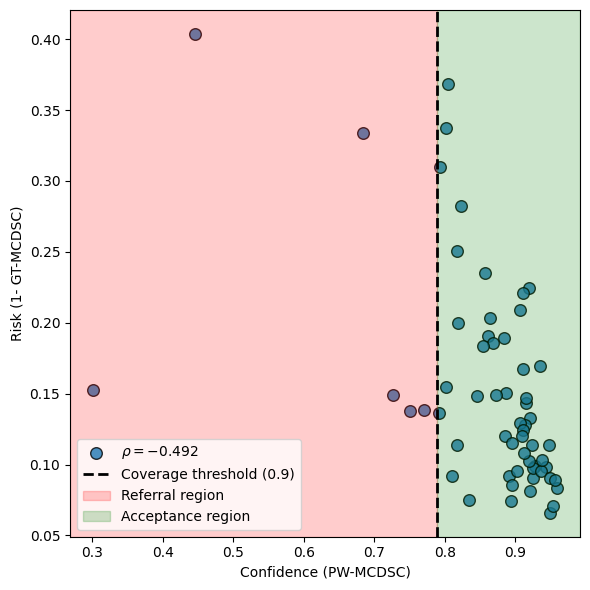

Saved scatter plot for model 'STAPLE' to /scratch/radv/share/glioseg/new_run_corrected/segQA/conf_vs_risk_STAPLe_micro.svg
Saved correlation summary to /scratch/radv/share/glioseg/new_run_corrected/segQA/corr_summary_STAPLe_micro.csv
   Pearson r = -0.492, p = 6.458e-05
Cases in the referral region: ['IM0191', 'IM0268', 'IM0392', 'IM1389', 'IM1398', 'IM1411']


['IM0191', 'IM0268', 'IM0392', 'IM1389', 'IM1398', 'IM1411']

In [46]:
plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_summary,
    multiclass_dice_score_df=multiclass_dice_score,
    model_keys="STAPLE",
    output_dir=output_dir,
    metric_compute="micro",
    experiment_name="STAPLe",
    fit_line=False,
    desired_coverage=0.9
)

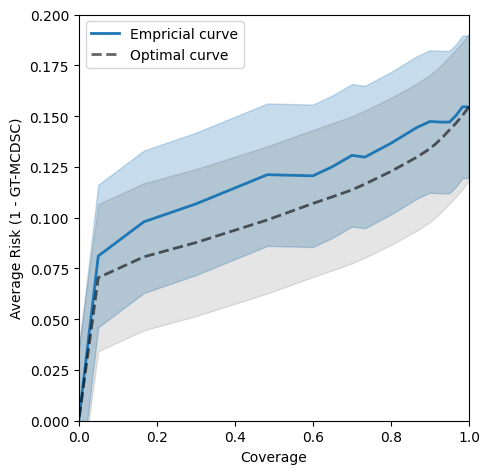

Saved figure to /scratch/radv/share/glioseg/new_run_corrected/segQA/rc_plot_STAPLE_micro.svg
Saved AUC table to /scratch/radv/share/glioseg/new_run_corrected/segQA/rc_auc_STAPLE_micro.csv
Saved detailed threshold data to /scratch/radv/share/glioseg/new_run_corrected/segQA/rc_detailed_STAPLE_micro.csv


In [68]:
plot_risk_coverage_curves(
    confidence_candidates_summary_df=confidence_summary,
    multiclass_dice_score_df=multiclass_dice_score,
    model_keys="STAPLE",
    output_dir=output_dir,
    metric_compute="micro",
    experiment_name="STAPLE"
)

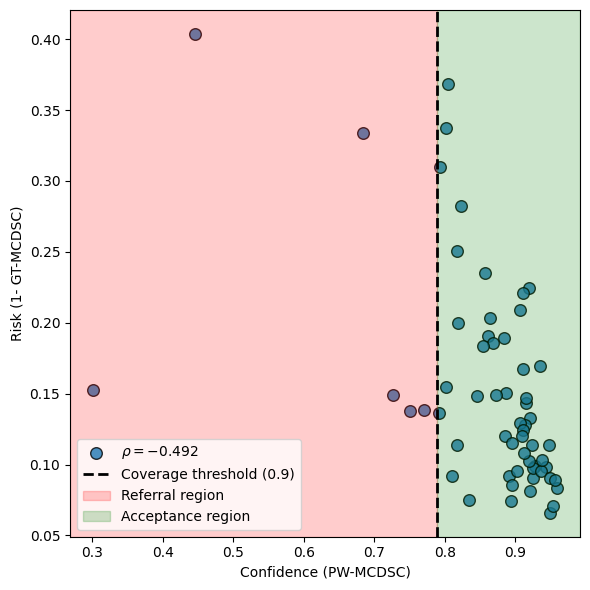

Saved scatter plot for model 'STAPLE' to /scratch/radv/share/glioseg/new_run_corrected/segQA/conf_vs_risk_STAPLE_micro.svg
Saved correlation summary to /scratch/radv/share/glioseg/new_run_corrected/segQA/corr_summary_STAPLE_micro.csv
   Pearson r = -0.492, p = 6.458e-05
Cases in the referral region: ['IM0191', 'IM0268', 'IM0392', 'IM1389', 'IM1398', 'IM1411']


In [13]:
referral_cases = plot_quality_vs_risk(
    confidence_candidates_summary_df=confidence_summary,
    multiclass_dice_score_df=multiclass_dice_score,
    model_keys="STAPLE",
    output_dir=output_dir,
    metric_compute="micro",
    experiment_name="STAPLE",
    desired_coverage=0.9
)

In [14]:
referral_cases

['IM0191', 'IM0268', 'IM0392', 'IM1389', 'IM1398', 'IM1411']

In [15]:
# Now we find the cases with the highest risk (top 5)
highest_risk_cases = multiclass_dice_score[multiclass_dice_score["Method"] == "STAPLE"].sort_values(by="GT-MCDSC").head(5)
print("Cases with highest risk (lowest GT-MCDSC):")
print(highest_risk_cases)

Cases with highest risk (lowest GT-MCDSC):
    Patient  Method    GT-DSC  GT-MCDSC
88   IM1389  STAPLE  0.865448  0.596343
97   IM1392  STAPLE  0.543873  0.631496
55   IM0398  STAPLE  0.810346  0.662769
10   IM0191  STAPLE  0.658104  0.666093
139  IM1412  STAPLE  0.569547  0.690043


In [16]:
# patients_of_interest = ["IM1411", "IM0398"]
import os 
from pathlib import Path
import pandas as pd
import numpy as np

tumor_volumes_df_dir = Path("/data/radv/radG/RAD/share/IMAGO/Rotterdam_project/Gonzalo_Juancito/tumor_volumes.xlsx")
tumor_volumes_df = pd.read_excel(tumor_volumes_df_dir)

#
data_dir = "/scratch/radv/share/glioseg/new_run_corrected/Patients" 
patients_of_interest = list(sorted(os.listdir(data_dir)))

# tumor_volumes_patients = tumor_volumes_df.loc[tumor_volumes_df["pseudo"].isin(patients_of_interest),["pseudo","Tumor_type"]]

# print(tumor_volumes_patients)

tumor_volumes_df_filtered = tumor_volumes_df.loc[tumor_volumes_df["pseudo"].isin(patients_of_interest)].reset_index(drop=True)

tumor_volumes_oligo = tumor_volumes_df_filtered.loc[(tumor_volumes_df_filtered["Tumor_type"] == "Oligo") | (tumor_volumes_df_filtered["Tumor_type"] == "Olgo")].reset_index(drop=True)
tumor_volumes_astro = tumor_volumes_df_filtered.loc[tumor_volumes_df_filtered["Tumor_type"] == "Astro"].reset_index(drop=True)
tumor_volumes_gbm = tumor_volumes_df_filtered.loc[tumor_volumes_df_filtered["Tumor_type"] == "glioblastoom"].reset_index(drop=True)

# Now we get how many cases are grade II, III, and IV in each group 

all_cases_grade, all_cases_counts = np.unique(tumor_volumes_df_filtered["Grade"], return_counts=True)
oligo_cases_grade, oligo_cases_counts = np.unique(tumor_volumes_oligo["Grade"], return_counts=True)
astro_cases_grade, astro_cases_counts = np.unique(tumor_volumes_astro["Grade"], return_counts=True)
gbm_cases_grade, gbm_cases_counts = np.unique(tumor_volumes_gbm["Grade"], return_counts=True) 

print("All cases tumor grades:")
for grade, count in zip(all_cases_grade, all_cases_counts):
    print(f"Grade {grade}: {count} cases")
print("\nOligodendroglioma cases tumor grades:")
for grade, count in zip(oligo_cases_grade, oligo_cases_counts):
    print(f"Grade {grade}: {count} cases")
print("\nAstrocytoma cases tumor grades:")
for grade, count in zip(astro_cases_grade, astro_cases_counts):
    print(f"Grade {grade}: {count} cases")
print("\nGlioblastoma cases tumor grades:")
for grade, count in zip(gbm_cases_grade, gbm_cases_counts):
    print(f"Grade {grade}: {count} cases")


All cases tumor grades:
Grade II: 27 cases
Grade III: 10 cases
Grade IV: 23 cases

Oligodendroglioma cases tumor grades:
Grade II: 14 cases
Grade III: 6 cases

Astrocytoma cases tumor grades:
Grade II: 13 cases
Grade III: 4 cases
Grade IV: 3 cases

Glioblastoma cases tumor grades:
Grade IV: 20 cases


In [17]:
all_cases_info = {"Non enhancing tumor": tumor_volumes_df_filtered["non_enh"].agg(["mean", "std"]),
                  "Enhancing tumor": tumor_volumes_df_filtered["enh"].agg(["mean", "std"]),
                  "Necrosis": tumor_volumes_df_filtered["nec"].agg(["mean", "std"])}

print("\nAll cases tumor volumes (mean ± std):")
for structure, stats in all_cases_info.items():
    print(f"{structure}: {stats['mean']:.2f} ± {stats['std']:.2f} voxels")

oligo_cases_info = {"Non enhancing tumor": tumor_volumes_oligo["non_enh"].agg(["mean", "std"]),
                   "Enhancing tumor": tumor_volumes_oligo["enh"].agg(["mean", "std"]),
                   "Necrosis": tumor_volumes_oligo["nec"].agg(["mean", "std"])}
print("\nOligodendroglioma cases tumor volumes (mean ± std):")
for structure, stats in oligo_cases_info.items():
    print(f"{structure}: {stats['mean']:.2f} ± {stats['std']:.2f} voxels")
astro_cases_info = {"Non enhancing tumor": tumor_volumes_astro["non_enh"].agg(["mean", "std"]),
                    "Enhancing tumor": tumor_volumes_astro["enh"].agg(["mean", "std"]),
                    "Necrosis": tumor_volumes_astro["nec"].agg(["mean", "std"])}
print("\nAstrocytoma cases tumor volumes (mean ± std):")
for structure, stats in astro_cases_info.items():
    print(f"{structure}: {stats['mean']:.2f} ± {stats['std']:.2f} voxels")
gbm_cases_info = {"Non enhancing tumor": tumor_volumes_gbm["non_enh"].agg(["mean", "std"]),
                  "Enhancing tumor": tumor_volumes_gbm["enh"].agg(["mean", "std"]),
                  "Necrosis": tumor_volumes_gbm["nec"].agg(["mean", "std"])}
print("\nGlioblastoma cases tumor volumes (mean ± std):")
for structure, stats in gbm_cases_info.items():
    print(f"{structure}: {stats['mean']:.2f} ± {stats['std']:.2f} voxels")


All cases tumor volumes (mean ± std):
Non enhancing tumor: 107233.70 ± 115066.34 voxels
Enhancing tumor: 10794.15 ± 22566.81 voxels
Necrosis: 8119.05 ± 20135.29 voxels

Oligodendroglioma cases tumor volumes (mean ± std):
Non enhancing tumor: 117815.10 ± 73799.14 voxels
Enhancing tumor: 3094.15 ± 11560.64 voxels
Necrosis: 2108.65 ± 9421.93 voxels

Astrocytoma cases tumor volumes (mean ± std):
Non enhancing tumor: 110077.85 ± 100850.54 voxels
Enhancing tumor: 4962.25 ± 12769.33 voxels
Necrosis: 13648.05 ± 30581.30 voxels

Glioblastoma cases tumor volumes (mean ± std):
Non enhancing tumor: 93808.15 ± 158686.00 voxels
Enhancing tumor: 24326.05 ± 31523.38 voxels
Necrosis: 8600.45 ± 12826.88 voxels


In [18]:
all_cases_info = {"Non enhancing tumor": tumor_volumes_df_filtered["non_enh"].agg(["median"]),
                  "Enhancing tumor": tumor_volumes_df_filtered["enh"].agg(["median"]),
                  "Necrosis": tumor_volumes_df_filtered["nec"].agg(["median"])}
print("\nAll cases tumor volumes (median):")
for structure, stats in all_cases_info.items():
    print(f"{structure}: {stats['median']:.2f} voxels")

oligo_cases_info = {"Non enhancing tumor": tumor_volumes_oligo["non_enh"].agg(["median"]),
                   "Enhancing tumor": tumor_volumes_oligo["enh"].agg(["median"]),
                   "Necrosis": tumor_volumes_oligo["nec"].agg(["median"])}
print("\nOligodendroglioma cases tumor volumes (median):")
for structure, stats in oligo_cases_info.items():
    print(f"{structure}: {stats['median']:.2f} voxels")
astro_cases_info = {"Non enhancing tumor": tumor_volumes_astro["non_enh"].agg(["median"]),
                    "Enhancing tumor": tumor_volumes_astro["enh"].agg(["median"]),
                    "Necrosis": tumor_volumes_astro["nec"].agg(["median"])}
print("\nAstrocytoma cases tumor volumes (median):")
for structure, stats in astro_cases_info.items():
    print(f"{structure}: {stats['median']:.2f} voxels")
gbm_cases_info = {"Non enhancing tumor": tumor_volumes_gbm["non_enh"].agg(["median"]),
                  "Enhancing tumor": tumor_volumes_gbm["enh"].agg(["median"]),
                  "Necrosis": tumor_volumes_gbm["nec"].agg(["median"])}
print("\nGlioblastoma cases tumor volumes (median):")
for structure, stats in gbm_cases_info.items():
    print(f"{structure}: {stats['median']:.2f} voxels") 


All cases tumor volumes (median):
Non enhancing tumor: 81743.00 voxels
Enhancing tumor: 453.00 voxels
Necrosis: 0.00 voxels

Oligodendroglioma cases tumor volumes (median):
Non enhancing tumor: 94904.00 voxels
Enhancing tumor: 0.00 voxels
Necrosis: 0.00 voxels

Astrocytoma cases tumor volumes (median):
Non enhancing tumor: 81743.00 voxels
Enhancing tumor: 0.00 voxels
Necrosis: 0.00 voxels

Glioblastoma cases tumor volumes (median):
Non enhancing tumor: 39282.00 voxels
Enhancing tumor: 19337.00 voxels
Necrosis: 3664.50 voxels


In [19]:
# def confidence_heatmaps_single_folder(config: configIO.Config, this_patient_folder: str) -> None:
#     """Create model agreement heatmaps for a single patient folder.

#     Args:
#         config (configIO.Config): Configuration object containing config settings.
#         this_patient_folder (str): Name of the patient folder.
#     """
#     print(f"Now creating heatmap for patient {this_patient_folder}")
#     patient_folder = config.input_data_path.joinpath(this_patient_folder)

#     segmentation_folder = patient_folder.joinpath(
#         constants.SEGMENTATIONS_FOLDER_NAME,
#         constants.ATLAS_REGISTRATION_FOLDER_NAME,
#     )

#     tumor_segmentations = constants.ALL_SEGMENTATIONS.copy()
#     if not config.evaluate_fets:
#         tumor_segmentations.remove(constants.FETS_SEGMENTATION_NAME)

#     # Load all relabelled model segmentations
#     tumor_segmentation_images = []
#     loaded_model_names = []

#     for seg_name in tumor_segmentations:
#         f = segmentation_folder.joinpath(
#             constants.TUMOR_MASK_NAME
#             + seg_name
#             + constants.RELABELLED_NAME
#             + constants.NIFTI_EXTENSION
#         )
#         if f.exists():
#             tumor_segmentation_images.append(sitk.ReadImage(f, sitk.sitkUInt8))
#             loaded_model_names.append(seg_name)
#         else:
#             print(f"{this_patient_folder} is missing segmentation file: {f}")

#     if len(tumor_segmentation_images) == 0:
#         print(f"No segmentations found for patient {this_patient_folder}, skipping.")
#         return

#     tumor_segmentation_arrays = [sitk.GetArrayFromImage(img) for img in tumor_segmentation_images]
#     tumor_segmentation_arrays = np.stack(tumor_segmentation_arrays, axis=0)

#     # Load STAPLE segmentation
#     staple_segmentation_file = segmentation_folder.joinpath(
#         constants.TUMOR_MASK_NAME
#         + constants.ENSEMBLED_SEGMENTATION_NAME
#         + constants.RELABELLED_NAME
#         + constants.NIFTI_EXTENSION
#     )
#     staple_segmentation_image = sitk.ReadImage(staple_segmentation_file, sitk.sitkUInt8)
#     staple_segmentation_array = sitk.GetArrayFromImage(staple_segmentation_image)

#     # ------------------------------------------------------------------
#     # Direct voxel-wise agreement calculation:
#     #   numerator = # models that agree with STAPLE at each voxel
#     #   denominator = # models that are ELIGIBLE to predict that label
#     #
#     #   Special case: HDGLIO cannot segment label 2 (necrosis), so it is
#     #   excluded from the denominator (and numerator) when STAPLE == 2.
#     # ------------------------------------------------------------------
#     agree_num = np.zeros_like(staple_segmentation_array, dtype=np.float32)
#     denom = np.zeros_like(staple_segmentation_array, dtype=np.float32)

#     for m, model_name in enumerate(loaded_model_names):
#         model_arr = tumor_segmentation_arrays[m]

#         # By default, model is eligible everywhere
#         eligible_mask = np.ones_like(staple_segmentation_array, dtype=bool)

#         # HDGLIO cannot segment necrosis or cysts (label 2/4) -> not eligible there
#         if model_name == constants.HDGLIO_SEGMENTATION_NAME:
#             eligible_mask = ~np.isin(staple_segmentation_array, [2, 4])

#         # Update denominator: count this model where it is eligible
#         denom += eligible_mask.astype(np.float32)

#         # Update numerator: model agrees with STAPLE AND is eligible
#         agree_mask = (model_arr == staple_segmentation_array) & eligible_mask
#         agree_num += agree_mask.astype(np.float32)

#     # Avoid division by zero
#     agreement = np.zeros_like(agree_num, dtype=np.float32)
#     valid = denom > 0
#     agreement[valid] = agree_num[valid] / denom[valid]

#     agree_img = sitk.GetImageFromArray(agreement)
#     agree_img.CopyInformation(tumor_segmentation_images[0])

#     tumor_mask = staple_segmentation_array > 0
#     overall_agreement = float(np.mean(agreement[tumor_mask])) if np.any(tumor_mask) else 0.0

#     # Save results
#     output_path = input_dir.joinpath(
#         constants.AGREEMENT_STAPLE_HEATMAP + constants.NIFTI_EXTENSION
#     )
#     sitk.WriteImage(
#         agree_img,
#         str(output_path),
#     )

#     print(
#         f"Done: overall agreement = {overall_agreement:.4f} " f"for patient {this_patient_folder}"
#     )

In [20]:
patients = ["IM1396", "IM0373","IM0352"]

confidence_patients = confidence_summary.loc[
    confidence_summary["Patient"].isin(patients), ["Patient", "PW-DSC"]
].reset_index(drop=True)

quality_patients = multiclass_dice_score.loc[
    (multiclass_dice_score["Method"] == "MV") & (multiclass_dice_score["Patient"].isin(patients)),
    ["Patient", "GT-MCDSC"],
].reset_index(drop=True)

print("Detailed confidence and quality for selected patients:")
detailed_df = confidence_patients.merge(
    quality_patients, on="Patient", how="inner"
)
print(detailed_df)

Detailed confidence and quality for selected patients:
  Patient    PW-DSC  GT-MCDSC
0  IM0352  0.978800  0.912978
1  IM0373  0.613633  0.799058
2  IM1396  0.706614  0.865166


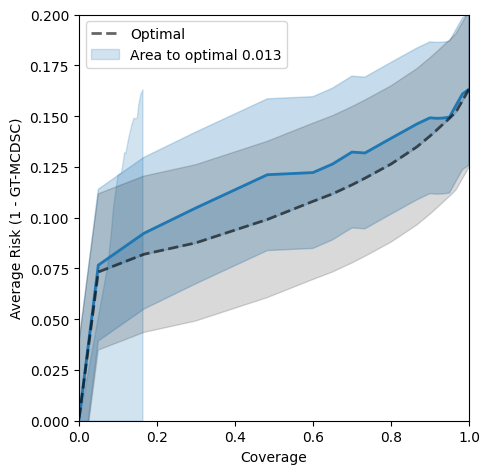

Saved figure to /scratch/radv/share/glioseg/new_run_corrected/segQA/rc_plot_MV_micro.svg
Saved AUC table to /scratch/radv/share/glioseg/new_run_corrected/segQA/rc_auc_MV_micro.csv
Saved detailed threshold data to /scratch/radv/share/glioseg/new_run_corrected/segQA/rc_detailed_MV_micro.csv


<Figure size 640x480 with 0 Axes>

In [21]:
plot_risk_coverage_curves(
    confidence_candidates_summary_df=confidence_summary,
    multiclass_dice_score_df=multiclass_dice_score,
    model_keys="MV",
    output_dir=output_dir,
    metric_compute="micro",
    experiment_name="MV"
)

In [22]:
tumor_volumes_df_dir = Path("/data/radv/radG/RAD/share/IMAGO/Rotterdam_project/Gonzalo_Juancito/tumor_volumes.xlsx")
tumor_volumes_df = pd.read_excel(tumor_volumes_df_dir)

tumor_volumes_patients = tumor_volumes_df.loc[tumor_volumes_df["pseudo"].isin(patients),["pseudo","Tumor_type"]]

In [23]:
tumor_volumes_patients

,pseudo,Tumor_type
13,IM0352,Oligo
16,IM0373,Astro
38,IM1396,Astro
